In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
india_df = pd.read_csv('covid_19_india.csv')
vaccine_df = pd.read_csv('covid_vaccine_statewise.csv')

## Preprocessing
* Convert date to datetime object
* Convert `-` values to `0` for unrecorded ConfirmedIndianNational & ConfirmedForeignNational
* Remove `*` from certain state names

In [3]:
print('Original dtypes')
india_df.dtypes

Original dtypes


Sno                          int64
Date                        object
Time                        object
State/UnionTerritory        object
ConfirmedIndianNational     object
ConfirmedForeignNational    object
Cured                        int64
Deaths                       int64
Confirmed                    int64
dtype: object

In [4]:
india_df['Date'] = pd.to_datetime(india_df['Date'], format='%Y-%m-%d')
india_df['ConfirmedIndianNational'] = india_df['ConfirmedIndianNational'].apply(lambda x: 0 if x == '-' else int(x))
india_df['ConfirmedForeignNational'] = india_df['ConfirmedForeignNational'].apply(lambda x: 0 if x == '-' else int(x))
india_df['State/UnionTerritory'] = india_df['State/UnionTerritory'].apply(lambda x: x[:x.find('*')] if x.find('*') != -1 else x)

## 1.1

In [5]:
print('Modified dtypes w/ column names')
india_df.dtypes

Modified dtypes w/ column names


Sno                                  int64
Date                        datetime64[ns]
Time                                object
State/UnionTerritory                object
ConfirmedIndianNational              int64
ConfirmedForeignNational             int64
Cured                                int64
Deaths                               int64
Confirmed                            int64
dtype: object

In [6]:
print('Unique values/ranges for categorical values')
print('Unique states')
print(india_df['State/UnionTerritory'].unique())
print('Unique time values')
print(india_df['Time'].unique())
print('Date range')
print(india_df['Date'].min(), 'to', india_df['Date'].max())

Unique values/ranges for categorical values
Unique states
['Kerala' 'Telengana' 'Delhi' 'Rajasthan' 'Uttar Pradesh' 'Haryana'
 'Ladakh' 'Tamil Nadu' 'Karnataka' 'Maharashtra' 'Punjab'
 'Jammu and Kashmir' 'Andhra Pradesh' 'Uttarakhand' 'Odisha' 'Puducherry'
 'West Bengal' 'Chhattisgarh' 'Chandigarh' 'Gujarat' 'Himachal Pradesh'
 'Madhya Pradesh' 'Bihar' 'Manipur' 'Mizoram'
 'Andaman and Nicobar Islands' 'Goa' 'Unassigned' 'Assam' 'Jharkhand'
 'Arunachal Pradesh' 'Tripura' 'Nagaland' 'Meghalaya'
 'Dadra and Nagar Haveli and Daman and Diu'
 'Cases being reassigned to states' 'Sikkim' 'Daman & Diu' 'Lakshadweep'
 'Telangana' 'Dadra and Nagar Haveli' 'Himanchal Pradesh' 'Karanataka']
Unique time values
['6:00 PM' '10:00 AM' '7:30 PM' '9:30 PM' '8:30 PM' '5:00 PM' '8:00 AM']
Date range
2020-01-30 00:00:00 to 2021-08-11 00:00:00


In [7]:
print('Ranges for numerical/continuous columns')
india_df.describe().loc[['min', 'max']]

Ranges for numerical/continuous columns


,Sno,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
min,1.0,0.0,0.0,0.0,0.0,0.0
max,18110.0,177.0,14.0,6159676.0,134201.0,6363442.0


## 1.2
* Grouping data month wise and plotting Cured/Deaths/Confirmed.

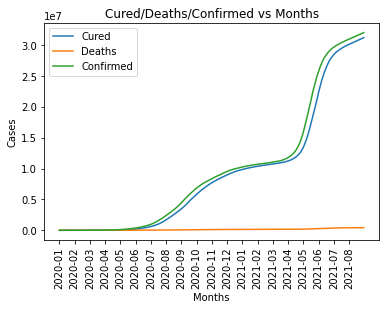

In [18]:
# group by months for x ticks
month_criteria = india_df['Date'].dt.to_period("M")
x_months = list(map(str, month_criteria.unique()))

# group by date, to show total at each date
date_criteria = india_df['Date'].dt.to_period("D")
date_grouped_df = india_df.groupby(date_criteria)[['Cured', 'Deaths', 'Confirmed']].sum()
dates = list(map(str, date_grouped_df.index))

# calculate spacing for x ticks
x_months_spacing = (np.arange(len(x_months)) * len(dates)) // len(x_months)

plt.plot(dates, date_grouped_df.Cured, label='Cured')
plt.plot(dates, date_grouped_df.Deaths, label='Deaths')
plt.plot(dates, date_grouped_df.Confirmed, label='Confirmed')

plt.xticks(x_months_spacing, x_months, rotation=90)
plt.xlabel('Months')
plt.ylabel('Cases')
plt.title('Cured/Deaths/Confirmed vs Months')
plt.legend()
plt.show()

## 1.3